<h2> Proyecto final</h2>

In [1]:
from jupyterthemes import jtplot
jtplot.style()

# Constantes
SEED = 42
PNLN = 0.0001

m = 64
tau = 1
delta = 2

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
#%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from keras import regularizers
from matplotlib import pyplot as plt

Using TensorFlow backend.


In [3]:
def TS2DBS(TS, m, tau, delta):
    N = TS.size
    DBSize = N-delta-(m-1)*tau
    DB = np.array([TS[slice(i,i+m*tau,tau)] for i in range(DBSize)])
    Y = np.array([TS[slice(i+m*tau,i+m*tau+delta,tau)] for i in range(DBSize)])
    return DB,Y


In [4]:
def GenersConjuntos(serie, test_siz, val_size):
    # Estazndarizacion de los Datos
    serie_std = (serie - serie.mean()) / serie.std()
    # Creacion de la base de datos
    X,y = TS2DBS(serie_std,m,tau,delta)
    # Cracion del Train_set
    X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_siz, random_state=SEED)
                    
    # Cracion del validation set
    X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=val_size, random_state=SEED)
    
    return X_train, X_val, y_train, y_val 

In [5]:
def ModMLP(show=True):
    inputs = keras.Input(shape=(m))
    x = layers.Dense(64, activation='sigmoid')(inputs)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(256, activation='relu')(x)
    outputs = layers.Dense(delta, activation='linear')(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name='forecasting')
    
    if(show):
        model.summary()
    
    return model

In [6]:
def ModMLPReg(show=True):
    inputs = keras.Input(shape=(m))
    x = layers.Dense(64, activation='sigmoid',activity_regularizer=regularizers.l1(PNLN))(inputs)
    x = layers.Dense(128, activation='relu',activity_regularizer=regularizers.l1(PNLN))(x)
    x = layers.Dense(256, activation='relu',activity_regularizer=regularizers.l1(PNLN))(x)
    outputs = layers.Dense(delta, activation='linear')(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name='forecasting')
    
    if(show):
        model.summary()
    
    return model

In [7]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  
  plt.figure(figsize=(16, 12))
  plt.subplot(221)
  #plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['loss'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_loss'],
           label = 'Val Error')

  #plt.ylim([0,20])
  plt.legend(loc="upper right")

  plt.subplot(224)
  #plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Precisión')
  plt.plot(hist['epoch'], hist['acc'],
           label='Train ACC')
  plt.plot(hist['epoch'], hist['val_acc'],
           label = 'Val ACC')
  #plt.ylim([0,20])
  plt.legend(loc="lower right")

  plt.subplot(222)
  plt.xlabel('Epoch')
  plt.ylabel('mean_absolute_error')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train MAE')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val MAE')
  #plt.ylim([0,20])
  plt.legend(loc="upper right")
    
  plt.subplot(223)
  plt.xlabel('Epoch')
  plt.ylabel('mean_squared_error')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train MSE')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val MSE')
  #plt.ylim([0,20])
  plt.legend(loc="upper right")
  
  plt.show()

In [8]:
def Noise(muestras, sigma, mean):
    N = np.random.normal(mean, sigma, size=muestras)
    return N

<h3>1) Series de tiempo y MLP </h3>

Los datos de la serie de tiempo se encuentran en un archivo csv, por lo cual se utiliza pandas para leer los datos. Posteriormente se realiza una revición a los datos por medio del metodo info() con la finalidad de encontrar valores nulos

In [9]:
TS = pd.read_csv('TimesSeries\Electric_Production.csv')

In [10]:
TS.info() # Se reviza que la serie de tiempo no tenga nulos

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 2 columns):
DATE     397 non-null object
Value    397 non-null float64
dtypes: float64(1), object(1)
memory usage: 6.3+ KB


In [11]:
serie = TS.Value

In [12]:
serie.mean()

88.84721763224182

In [13]:
serie.max()

129.4048

In [14]:
serie.min()

55.3151

In [15]:
serie.std()

15.387833664730902

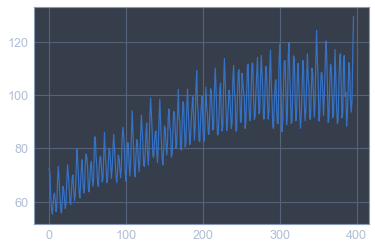

In [16]:
serie = np.array(serie)
plt.plot(serie)
plt.show()

Una vez que se ha revizado que la serie de tiempo no tiene valores nulos se aplica una estandarizacion a los datos, con la finalidad de mejorar el entrenamiento de la red neuronal MLP. Para realizar esta estandarizacion se utiliza la clase StandardScaler de Sklearn.

In [17]:
serie = serie / serie.max()

In [18]:
serie_std = (serie - serie.mean()) / serie.std()

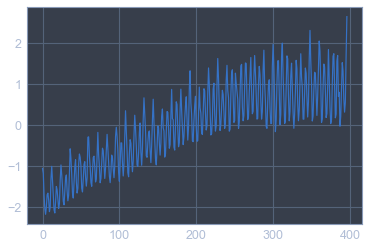

In [19]:
plt.plot(serie_std)
plt.grid(True)
plt.show()

Después de que se estandarizo para mantenerlo alrededor del cero, se aplica la función TS2DBS para obtener una base de datos a partir de la serie de tiempo.

In [20]:

X,y = TS2DBS(serie_std,m,tau,delta)

Para terminar con el tratamiento de los datos se divide en train y test. Posteriormente del train se obtiene el validation

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

In [22]:
X_train.shape

(232, 64)

In [23]:
X_test.shape

(100, 64)

In [24]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42)

In [25]:
X_train.shape

(185, 64)

In [26]:
X_val.shape

(47, 64)

In [27]:
X_test

array([[-1.22232419, -1.51200874, -1.86672266, ..., -0.93176122,
        -1.24951628, -1.40995545],
       [ 0.90921272,  1.68264184,  1.61035084, ...,  1.67176891,
         1.73528869,  0.90552334],
       [-0.73461696, -1.00740324, -1.4118034 , ..., -0.12438591,
        -0.75647344, -0.7915323 ],
       ...,
       [ 0.12821615,  0.20896604,  0.78865398, ...,  0.25461804,
         0.79987177,  1.57390603],
       [-1.28956589, -0.99867106, -0.28183194, ..., -0.44262248,
         0.21171844,  0.38681752],
       [-1.29992478, -1.22200536, -1.60927951, ..., -0.80098023,
        -1.0731809 , -1.28956589]])

<h3>Red Neuronal MLP</h3>

Primeramente se crea la arquitectura de la red neuronal, para  esto se utiliza tensorflow en combinacion con keras

In [41]:
model = ModMLP()

Model: "forecasting"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_6 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 514       
Total params: 46,018
Trainable params: 46,018
Non-trainable params: 0
_________________________________________________________________


Una vez que el modelo esta creado se compila y se entrena.

En la compilación se utiliza como funcion de perdida el Error cuadratico medio en convinacion con el gradiente estocastico, el tercer parametro son las metricas en este caso se utilizan el error absoluto medio, el error cuadratico medio y accuracy, aunque la ultima no es una buena referencia cuando se realiza prediccion de series de tiempo (forcasting) es más comun su utilización en clasificación.

In [42]:
X_train.shape

(185, 64)

In [43]:
model.compile(loss="mean_squared_error", optimizer="sgd", metrics=['mae', 'mse','accuracy'])

In [52]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train,
                    batch_size=64,
                    callbacks=[callback],
                    epochs=1000,
                    validation_data=(X_val, y_val))

test_scores = model.evaluate(X_test, y_test, batch_size=32)
print('Test loss:', test_scores[0])
print('Test mae:', test_scores[1])
print('Test mse:', test_scores[2])
print('Test acc:', test_scores[3])

Train on 185 samples, validate on 47 samples
Epoch 1/1000
185/185 [==============================] - 0s 1ms/sample - loss: 0.0434 - mean_absolute_error: 0.1601 - mean_squared_error: 0.0434 - acc: 0.8973 - val_loss: 0.0381 - val_mean_absolute_error: 0.1463 - val_mean_squared_error: 0.0381 - val_acc: 0.8936
Epoch 2/1000
185/185 [==============================] - 0s 146us/sample - loss: 0.0435 - mean_absolute_error: 0.1598 - mean_squared_error: 0.0435 - acc: 0.9027 - val_loss: 0.0383 - val_mean_absolute_error: 0.1468 - val_mean_squared_error: 0.0383 - val_acc: 0.8936
Epoch 3/1000
185/185 [==============================] - 0s 172us/sample - loss: 0.0434 - mean_absolute_error: 0.1609 - mean_squared_error: 0.0434 - acc: 0.8973 - val_loss: 0.0381 - val_mean_absolute_error: 0.1462 - val_mean_squared_error: 0.0381 - val_acc: 0.8936
Epoch 4/1000
185/185 [==============================] - 0s 161us/sample - loss: 0.0432 - mean_absolute_error: 0.1592 - mean_squared_error: 0.0432 - acc: 0.8973 - val

Epoch 32/1000
185/185 [==============================] - 0s 156us/sample - loss: 0.0422 - mean_absolute_error: 0.1572 - mean_squared_error: 0.0422 - acc: 0.9027 - val_loss: 0.0374 - val_mean_absolute_error: 0.1456 - val_mean_squared_error: 0.0374 - val_acc: 0.8936
Epoch 33/1000
185/185 [==============================] - 0s 130us/sample - loss: 0.0422 - mean_absolute_error: 0.1575 - mean_squared_error: 0.0422 - acc: 0.8973 - val_loss: 0.0376 - val_mean_absolute_error: 0.1456 - val_mean_squared_error: 0.0376 - val_acc: 0.8936
Epoch 34/1000
185/185 [==============================] - 0s 135us/sample - loss: 0.0420 - mean_absolute_error: 0.1563 - mean_squared_error: 0.0420 - acc: 0.8973 - val_loss: 0.0377 - val_mean_absolute_error: 0.1458 - val_mean_squared_error: 0.0377 - val_acc: 0.8936
Epoch 35/1000
185/185 [==============================] - 0s 134us/sample - loss: 0.0420 - mean_absolute_error: 0.1573 - mean_squared_error: 0.0420 - acc: 0.8973 - val_loss: 0.0375 - val_mean_absolute_error

In [1]:
plot_history(history)

NameError: name 'plot_history' is not defined

In [46]:
muestra = X_test[0]
#muestra.reshape(1,64)

In [47]:
y_test[0:4]

array([[-1.14776881, -0.73781833],
       [ 0.17174691,  0.26305741],
       [-0.45005329, -0.18782761],
       [ 0.75981566,  1.43821237]])

In [48]:
y_predic= model.predict(X_test)

In [49]:
r = y_test - y_predic

In [50]:
r.mean()

0.002051248316462735

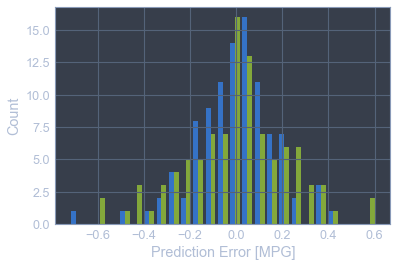

In [51]:

plt.hist(r, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

<h3>Guardar el modelo entrenado </h3>

El modelo que fue generado atravez del entrenamiento es guardado con la finalidad de utilizarlo sin la necesidad de volver a entrenar

In [39]:
#model.save('modelo_serie_electrica3.h5')

<h2>Adicion de ruido blanco a la serie de Tiempo</h2>

En esta sección se añade el ruido blanco en la señal, para lo cual primero se dividira la señal en conjunto de entrenamiento y conjunto de prueba

In [40]:
X_train_e, X_val_e, y_train_e, y_val_e =  GenersConjuntos(serie_e, 0.3, 0.2)

NameError: name 'serie_e' is not defined

In [ ]:
len = serie.size
e = Noise(len, 1, 0)

In [ ]:
X_train_e = X_train_e + e 

In [ ]:
plt.plot(serie_e)
plt.show()

In [ ]:
modelE = ModMLPR()

In [ ]:
modelE.compile(loss="mean_squared_error", optimizer="sgd", metrics=['mae', 'mse','accuracy'])

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
history = modelE.fit(X_train, y_train,
                    batch_size=64,
                    callbacks=[callback],
                    epochs=200,
                    validation_data=(X_val, y_val))

test_scores = modelE.evaluate(X_test, y_test, batch_size=32)
print('Test loss:', test_scores[0])
print('Test accuracy:', test_scores[1])

In [ ]:
plot_history(history)